In [591]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [592]:
df=pd.read_excel('LME_COPPER.xlsx',sheetname='Sheet1')

In [593]:
N_col=df.shape[1]
update_date=df.iloc[3:,0]
new_df=pd.DataFrame()
new_df['update_date']=update_date
for i in range(1,N_col,2):
    indicator_name=df.iloc[1,i]
    data=df.iloc[30:,i]
    new_df[indicator_name]=data

In [594]:
new_df['update_date']=pd.to_datetime(new_df['update_date'])
new_df['NON-COMMERCIAL LONG']=new_df['NON-COMMERCIAL LONG'].astype(float)
new_df['NON-COMMERCIAL SHORT']=new_df['NON-COMMERCIAL SHORT'].astype(float)
new_df['COMMERCIAL LONG']=new_df['COMMERCIAL LONG'].astype(float)
new_df['COMMERCIAL SHORT']=new_df['COMMERCIAL SHORT'].astype(float)
new_df['OPEN INTEREST']=new_df['OPEN INTEREST'].astype(float)

In [595]:
cufi=pd.read_csv('CUFI_0112.csv',encoding='gbk')
cufi['update_date']=pd.to_datetime(cufi['update_date'])

In [596]:
# cufi_close=cufi[['update_date','close','open','high','low']]
cufi_close=cufi[['update_date','high','low']]

In [597]:
cufi_intraday=pd.read_csv('CU_intraday_2year.csv',encoding='gbk')
cufi_intraday['update_date']=pd.to_datetime(cufi_intraday['update_date'])
cufi_intraday['date']=cufi_intraday['update_date'].apply(lambda x:x.date())

In [598]:
cufi_1stmin=pd.DataFrame()
cufi_lastmin=pd.DataFrame()
for i,j in cufi_intraday.groupby(['date']):
    j=j.sort(['update_date'])
    t=j.iloc[0,:]
    l=j.iloc[-1,:]
    cufi_1stmin=cufi_1stmin.append(t)
    cufi_lastmin=cufi_lastmin.append(l)

/Users/liyuefan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [599]:
cufi_1stmin=cufi_1stmin[['date','open']]
cufi_lastmin=cufi_lastmin[['date','close']]
cufi_1stmin=cufi_1stmin.rename(columns={'date':'update_date','open':'open'})
cufi_lastmin=cufi_lastmin.rename(columns={'date':'update_date'})
cufi_1stmin['update_date']=pd.to_datetime(cufi_1stmin['update_date'])
cufi_lastmin['update_date']=pd.to_datetime(cufi_lastmin['update_date'])

In [600]:
cufi_close=pd.merge(cufi_close,cufi_1stmin,on=['update_date'],how='inner')
cufi_close=pd.merge(cufi_close,cufi_lastmin,on=['update_date'],how='inner')

In [601]:
new_df=pd.merge(new_df,cufi_close,on=['update_date'],how='inner')

In [602]:
new_df.index=[new_df['update_date']]

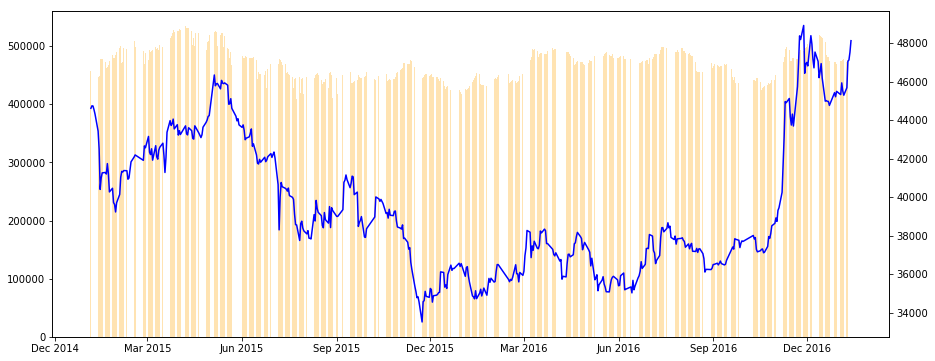

In [603]:
plt.figure(figsize=(15,6))
plt.bar(new_df.index,new_df['OPEN INTEREST'],color='orange',alpha=0.3)
ax2=plt.twinx()
ax2.plot(new_df['close'],color='blue')

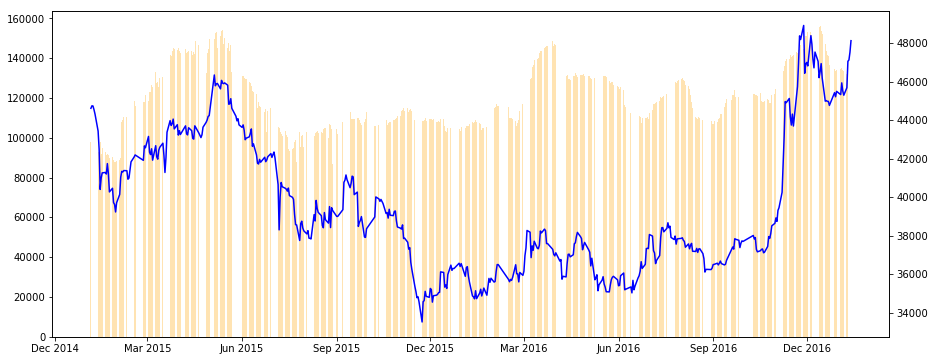

In [604]:
plt.figure(figsize=(15,6))
plt.bar(new_df.index,new_df['NON-COMMERCIAL LONG'],color='orange',alpha=0.3)
ax2=plt.twinx()
ax2.plot(new_df['close'],color='blue')

In [605]:
new_df['NON-COMMERCIAL LONG PERCENTAGE']=new_df['NON-COMMERCIAL LONG']/new_df['OPEN INTEREST']
new_df['NON-COMMERCIAL SHORT PERCENTAGE']=new_df['NON-COMMERCIAL SHORT']/new_df['OPEN INTEREST']
new_df['COMMERCIAL SHORT PERCENTAGE']=new_df['COMMERCIAL SHORT']/new_df['OPEN INTEREST']
new_df['COMMERCIAL LONG PERCENTAGE']=new_df['COMMERCIAL LONG']/new_df['OPEN INTEREST']

In [606]:
new_df['NET NON-COMMERCIAL PERCENTAGE']=new_df['NON-COMMERCIAL LONG PERCENTAGE']-new_df['NON-COMMERCIAL SHORT PERCENTAGE']

In [607]:
new_df['pct_chg']=np.log(new_df['close'])
new_df['pct_chg']=new_df['pct_chg'].diff()

In [608]:
cftc=pd.read_csv('CFTC_CU.csv',encoding='gbk',thousands=',')

cftc_data=cftc.iloc[1:,:]
cftc_cln=pd.DataFrame(cftc_data)
cftc_cln.columns=['update_date','non_comm_long','non_comm_short','non_comm_arb','comm_long','comm_short','open_interest']
cftc_cln=cftc_cln.dropna(axis=0)
cftc_cln['update_date']=pd.to_datetime(cftc_cln['update_date'])


def thousands(series):
    return series.str.replace(',','').astype(float)

for col in cftc_cln.columns:
    if col!='update_date':
        cftc_cln[col]=thousands(cftc_cln[col])
    else:
        pass

cftc_cln['non_comm_net']=cftc_cln['non_comm_long']-cftc_cln['non_comm_short']
cftc_cln['non_comm_per']=cftc_cln['non_comm_net']/cftc_cln['open_interest']

In [609]:
tmp_df=pd.merge(cftc_cln[['update_date','non_comm_per']],new_df[['update_date','close']],on=['update_date'],how='inner')
tmp_df.index=[tmp_df['update_date']]

In [610]:
new_df['NON_COMM_PER']=(new_df['NON-COMMERCIAL LONG']-new_df['NON-COMMERCIAL SHORT'])/new_df['OPEN INTEREST']
non_comm_per_df=pd.merge(new_df[['update_date','NON_COMM_PER']],cftc_cln[['update_date','non_comm_per']],on=['update_date'],how='inner')

In [611]:
non_comm_per_df.index=[non_comm_per_df['update_date']]

In [612]:
import statsmodels.api as sm

In [613]:
Y=np.array(non_comm_per_df['non_comm_per'])
X=np.array(non_comm_per_df['NON_COMM_PER'])
X=sm.add_constant(X)

In [614]:
X_full=np.array(new_df['NON_COMM_PER'])
X_full=sm.add_constant(X_full)

In [615]:
# result.params

In [616]:
# Y_full=np.sum(X_full*result.params,axis=1)

In [617]:
def rolling_lm(Y,X,step):
    if len(Y)==len(X):
        N=len(Y)
        full_cftc_array=np.zeros((N,2),dtype=np.float)
        for i in range(step-1,N):
            X_train=X[np.max((0,i-step+1)):i]
            Y_train=Y[np.max((0,i-step+1)):i]
            lm=sm.OLS(Y_train,X_train)
            result=lm.fit()
            param=result.params
            full_cftc_array[i,0]=param[0]
            full_cftc_array[i,1]=param[1]
    else:
        return None
    return full_cftc_array

In [618]:
Y_param=rolling_lm(Y,X,30)

In [619]:
non_comm_per_df['const']=Y_param[:,0]
non_comm_per_df['coef']=Y_param[:,1]

In [620]:
full_df=pd.DataFrame()
full_df['update_date']=new_df['update_date']
full_df['NON_COMM_PER']=new_df['NON_COMM_PER']
full_df=pd.merge(full_df,non_comm_per_df[['update_date','const','coef']],on=['update_date'],how='outer')
full_df['const']=full_df['const'].shift(4)
full_df['coef']=full_df['coef'].shift(4)
full_df['const']=full_df['const'].fillna(method='ffill')
full_df['coef']=full_df['coef'].fillna(method='ffill')
full_df['Y_full']=full_df['coef']*full_df['NON_COMM_PER']+full_df['const']
# full_df['Y_full']=Y_full
full_df=full_df.dropna(axis=0)
full_df=full_df.sort(['update_date'])

/Users/liyuefan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [621]:
full_df=pd.merge(full_df,non_comm_per_df[['update_date','non_comm_per']],on=['update_date'],how='outer')
full_df['non_comm_per']=full_df['non_comm_per'].fillna(method='ffill')
full_df.index=[full_df['update_date']]

In [622]:
full_df=pd.merge(full_df,new_df[['update_date','close','open','high','low']],on=['update_date'],how='inner')

In [623]:
full_df['close_ma']=pd.rolling_mean(full_df['close'],1)
full_df['Y_full_ma']=pd.rolling_mean(full_df['Y_full'],1)
# full_df['Y_full_ma']=full_df['Y_full_ma'].shift(1)
full_df['close_ma_diff']=full_df['close_ma'].diff()
full_df['Y_full_ma_diff']=full_df['Y_full_ma'].diff()

In [624]:
full_df=full_df.dropna(axis=0)

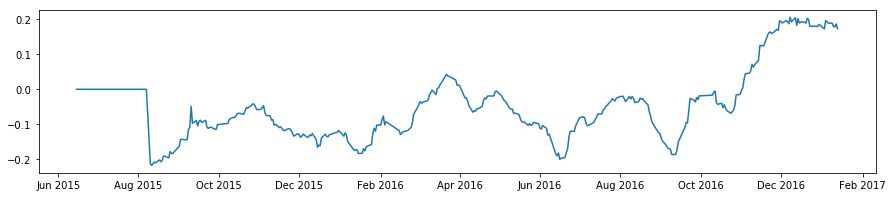

In [654]:
plt.figure(figsize=(15,3))
plt.plot(full_df['update_date'],full_df['Y_full'])

In [626]:
# c_upper_thr=full_df['close_ma_diff'].quantile(0.6)
# c_lower_thr=full_df['close_ma_diff'].quantile(0.4)
# y_upper_thr=full_df['Y_full_ma_diff'].quantile(0.6)
# y_lower_thr=full_df['Y_full_ma_diff'].quantile(0.4)

In [627]:
def c_(u,l):
    def cc(x):
        if x>=u:
            return 1
        elif x<=l:
            return -1
        else:
            return 0
    return cc

In [628]:
# compare_close=c_(c_upper_thr,c_lower_thr)
# compare_y=c_(y_upper_thr,y_lower_thr)

In [629]:
# full_df['close_ma_sig']=full_df['close_ma_diff'].apply(compare_close)
# full_df['Y_full_ma_sig']=full_df['Y_full_ma_diff'].apply(compare_y)

In [630]:
full_df['close_diff_qtl_up']=pd.rolling_quantile(full_df['close_ma_diff'],100,0.6)
full_df['close_diff_qtl_low']=pd.rolling_quantile(full_df['close_ma_diff'],100,0.4)
full_df['y_diff_qtl_up']=pd.rolling_quantile(full_df['Y_full_ma_diff'],100,0.6)
full_df['y_diff_qtl_low']=pd.rolling_quantile(full_df['Y_full_ma_diff'],100,0.4)

In [631]:
def cc_2(x,u,l):
    if x>=u:
        return 1
    elif x<=l:
        return -1
    else:
        return 0

In [632]:
full_df['close_ma_sig']=map(cc_2,full_df['close_ma_diff'],full_df['close_diff_qtl_up'],full_df['close_diff_qtl_low'])
full_df['Y_full_ma_sig']=map(cc_2,full_df['Y_full_ma_diff'],full_df['y_diff_qtl_up'],full_df['y_diff_qtl_low'])

In [633]:
def sig(x,y):
    if x==y and x!=0:
        return x
    elif x*y==-1:
        return -x
    else:
        return 0

In [634]:
full_df['dir']=map(sig,full_df['close_ma_sig'],full_df['Y_full_ma_sig'])

In [635]:
# full_df['r']=np.log(full_df['close'])
# full_df['r']=full_df['r'].diff()
full_df['r']=(full_df['close']-full_df['open'])/full_df['open']

# full_df['r']=np.log(full_df['open'])
# full_df['r']=full_df['r'].diff()

In [636]:
full_df['dir']=full_df['dir'].shift(1)

In [637]:
# full_df['close_yes']=full_df['close'].shift(1)
# can_trade=np.zeros(len(full_df))
# for i in range(len(full_df)):
#     if full_df.iloc[i,:]['dir']==1:
#         if full_df.iloc[i,:]['close_yes']>=full_df.iloc[i,:]['low']:
#             can_trade[i]=1
#         else:
#             pass
#     elif full_df.iloc[i,:]['dir']==-1:
#         if full_df.iloc[i,:]['close_yes']<=full_df.iloc[i,:]['high']:
#             can_trade[i]=1
#         else:
#             pass
# full_df['can_trade']=can_trade
# full_df['dir']=full_df['dir']*full_df['can_trade']

In [638]:
full_df['daily_r']=full_df['dir']*full_df['r']

In [639]:
full_df['cum_r']=full_df['daily_r'].cumsum()

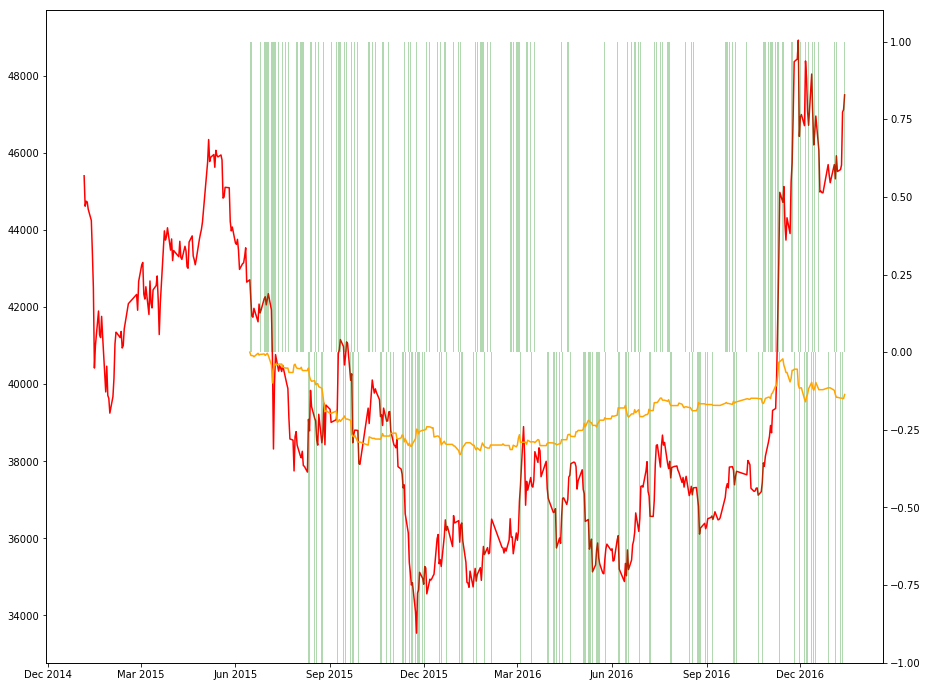

In [653]:
full_df.index=[full_df['update_date']]
plt.figure(figsize=(15,12))
# plt.plot(full_df.index,pd.rolling_mean(full_df['Y_full'],5),color='orange')
# # plt.bar(full_df.index,full_df['Y_full'],color='orange',alpha=0.5)
# ax2=plt.twinx()
# ax2.plot(new_df.index,pd.rolling_mean(new_df['close'],5))
plt.plot(new_df.index,new_df['open'],color='red')
ax2=plt.twinx()
ax2.bar(full_df.index,full_df['dir'],color='green',alpha=0.3)
# ax4=ax3.twinx()
ax2.plot(full_df.index,full_df['cum_r'],color='orange')

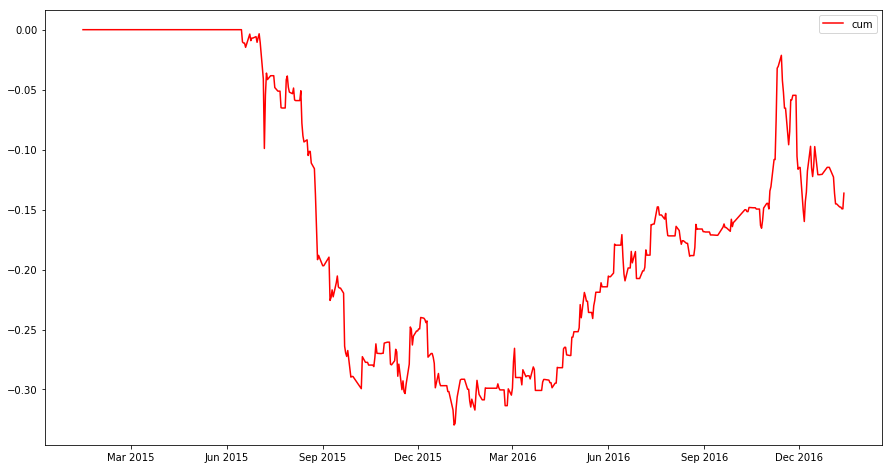

In [641]:
plt.figure(figsize=(15,8))
plt.plot(full_df['update_date'],full_df['cum_r'],color='red',label='cum')
# ax2=plt.twinx()
# ax2.plot(full_df['update_date'],full_df['close'],'b.-',label='close',alpha=0.6)
plt.legend()

In [642]:
len(full_df[full_df['dir']!=0])

273

In [643]:
(np.mean(full_df['daily_r'])*252-0.03)/(np.sqrt(252)*np.std(full_df['daily_r']))

-0.65447821724678568

In [644]:
full_df=full_df.dropna(axis=0)

In [645]:
reverse_df=full_df[full_df['close_ma_sig']!=full_df['Y_full_ma_sig']]

In [646]:
win_reverse=reverse_df[reverse_df['daily_r']>=0]

In [647]:
float(len(win_reverse))/len(reverse_df)

0.582010582010582

In [648]:
trend_df=full_df[full_df['close_ma_sig']==full_df['Y_full_ma_sig']][full_df['dir']!=0]

In [649]:
win_trend=trend_df[trend_df['daily_r']>=0]

In [650]:
float(len(win_trend))/len(trend_df)

0.5

In [651]:
np.mean(full_df['daily_r'])*252

-0.09040290691005792

In [652]:
full_df

,update_date,NON_COMM_PER,const,coef,Y_full,non_comm_per,close,open,high,low,...,close_diff_qtl_up,close_diff_qtl_low,y_diff_qtl_up,y_diff_qtl_low,close_ma_sig,Y_full_ma_sig,dir,r,daily_r,cum_r
2015-06-15,2015-06-15,0.043784,0.000000,0.000000,0.000000,-0.078011,42200,42710,42760.97,42143.17,...,110,-100,0.000000,0.000000,-1,1,0,-0.011941,-0.000000,0.000000
2015-06-16,2015-06-16,0.039380,0.000000,0.000000,0.000000,-0.090843,41770,42200,42355.03,41998.36,...,110,-100,0.000000,0.000000,-1,1,1,-0.010190,-0.010190,-0.010190
2015-06-17,2015-06-17,0.037831,0.000000,0.000000,0.000000,-0.090843,41730,41770,42066.35,41718.14,...,110,-100,0.000000,0.000000,0,1,1,-0.000958,-0.000958,-0.011147
2015-06-18,2015-06-18,0.027945,0.000000,0.000000,0.000000,-0.090843,41970,41740,42196.83,41602.22,...,110,-100,0.000000,0.000000,1,1,0,0.005510,0.000000,-0.011147
2015-06-19,2015-06-19,0.021802,0.000000,0.000000,0.000000,-0.090843,41820,41970,42047.59,41757.14,...,100,-100,0.000000,0.000000,-1,1,1,-0.003574,-0.003574,-0.014721
2015-06-23,2015-06-23,0.019179,0.000000,0.000000,0.000000,-0.128031,42080,41620,41957.48,41562.55,...,110,-100,0.000000,0.000000,1,1,1,0.011052,0.011052,-0.003669
2015-06-24,2015-06-24,0.017987,0.000000,0.000000,0.000000,-0.128031,41850,42080,42239.65,41747.52,...,110,-110,0.000000,0.000000,-1,1,1,-0.005466,-0.005466,-0.009135
2015-06-25,2015-06-25,0.006054,0.000000,0.000000,0.000000,-0.128031,41940,41850,42292.72,41447.10,...,100,-110,0.000000,0.000000,0,1,1,0.002151,0.002151,-0.006984
2015-06-26,2015-06-26,0.017689,0.000000,0.000000,0.000000,-0.128031,42110,41930,42510.61,41630.30,...,110,-100,0.000000,0.000000,1,1,0,0.004293,0.000000,-0.006984
2015-06-29,2015-06-29,0.016346,0.000000,0.000000,0.000000,-0.128031,42270,42220,42655.60,42014.86,...,110,-100,0.000000,0.000000,1,1,1,0.001184,0.001184,-0.005800
